# Social Media Analysis

With this notebook, you can analyse tweets that were posted in the same area and on the same day as the Napa earthquake in 2014 (see https://en.wikipedia.org/wiki/2014_South_Napa_earthquake for details).  

### Exercise

Create a new markdown cell to answer the following questions (5P):

* How many tweets are in the dataset?
* What words are the most frequent words in the wordcloud (related to the size of the words)?
* Perform  topic modelling with and without preprocessing. What can you observe?
* Which topics can you identify in the datasets? Can you label some of the topics?
* What is the min and max date of the dataset?
* How does the time-series of the disaster-related topic and the overall dataset differ?
* How does the heatmap of the disaster-related topic and the overall dataset differ?
* How do the wordclouds of the sentiments differ?
* How do the sentiments of the time-series for various topics differ?


### Answers

- There are 90907 Tweets in the dataset.  

- The longest and biggest word is "earthquake", the are also some surprising results with a big size such as "t", "co".  

- I observed that topic modelling did not really work when I did not preprocess the text. The most confusing outcome resulted when special characters where not removed. There was no chance in identifying any topic. Other preprocessing methods improved the modelling performance. Made the outcome more understandable.

- I can identify 3 topics from the 10 that were modelled. 4 Topics can be categorized into the following (see topic indices below):
  - ***earthquake*** (0,6)
  - ***schoolstart*** (4)
  - ***football game 49er*** (2)

- ***Min Date:*** 24.08.2014 07:00, ***Max Date:*** 25.08.2014 06:59 

- See below. A difference in the number of spikes regarding tweet volume can be seen. The overall data set time series has more spikes and generally a higher tweet volume. The disaster dataset has one spike when the earthquake occured.  

- The heatmap differs slightly. They look the same when zoomed out. When zoomed in, more holes and more empty spaces can be seen in the disaster related heatmap.

- As expected the words in the wordclouds for the sentiments differ in their meaning. The positive wordcloud mostly contains positive words such as "thank", "hope", "love", the negative wordcloud contains "earthquake", "worst", "killed", the neutral one "dude", "san francisco", "american".

- A drop from positive to negative sentiment can be seen for the disaster related tweets around the time when the earthquake occured. 


## Load dataset and libraries

In [211]:
%matplotlib inline
%pip install nltk gensim folium wordcloud pyLDAvis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/Users/izzy/.pyenv/versions/3.8.15/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [212]:
import gensim
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium
import pyLDAvis.gensim_models as gensimvis
import statistics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [231]:
#df = pd.read_excel('napa_tweets_with_pga.xlsx')
#df = pd.read_csv('napa_tweets_with_pga.csv', sep=';', error_bad_lines=False, index_col=False, warn_bad_lines=False)

df = pd.read_csv('./napa_tweets.csv', sep=',', index_col=False)
print("count", len(df["tweet_text"]))
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)
  

count 90907


id              time                                  tweet_text  \
0   0  24.08.2014 23:07                             SMITE vs LOL ??   
1   1  24.08.2014 23:12  Random people complimenting you is so nice   
2   2  24.08.2014 23:37                  Calum is being an annoying   
3   3  24.08.2014 23:38                                      Plan B   
4   4  24.08.2014 23:42                              Laaawwwwllllll   

    latitude   longitude  
0  37.600700 -122.014820  
1  38.417359 -122.709612  
2  37.353794 -121.863898  
3  37.957866 -122.032392  
4  38.338400 -122.685784

## Natural language processing

Create a wordcloud and find out the most prominent words in the corpus.

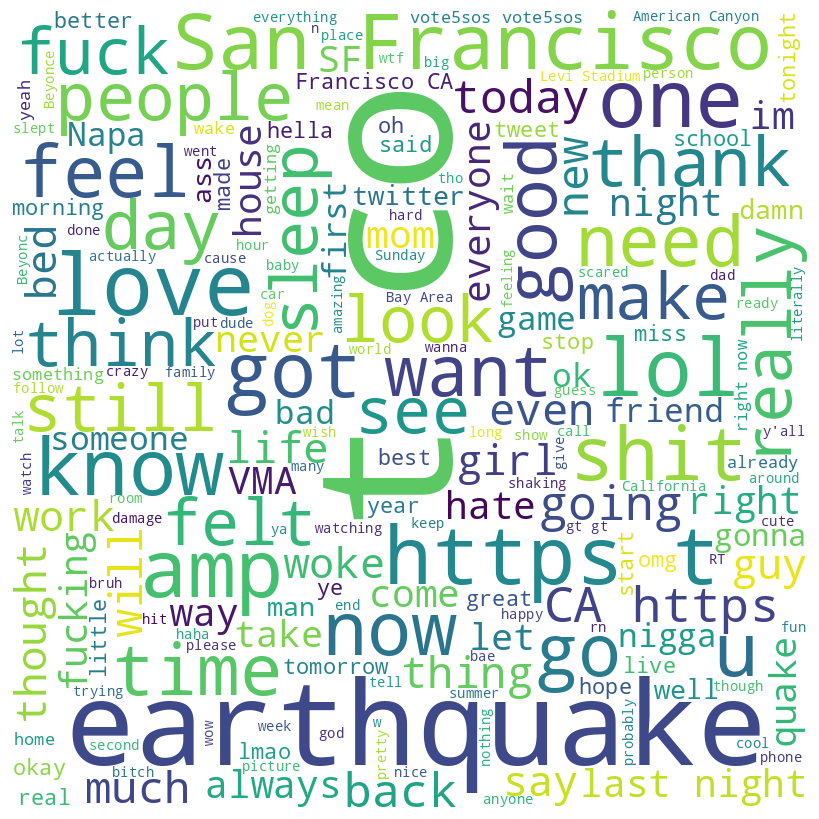

In [215]:
tweet_text = "".join(df.tweet_text)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=set(STOPWORDS),
                min_font_size = 10).generate(tweet_text)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Download nltk Ressources.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/izzy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/izzy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Transform tweets text into usable format

1. Lower case tweets text
2. Remove URL
3. Tokenize words

In [216]:
import re

def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

df["tweet_text"] = df["tweet_text"].str.lower() 
df["tweet_text"] = df["tweet_text"].apply(remove_urls)
tokenized_docs = df["tweet_text"].apply(nltk.word_tokenize).to_numpy()

print(tokenized_docs[:15])


[list(['smite', 'vs', 'lol', '?', '?'])
 list(['random', 'people', 'complimenting', 'you', 'is', 'so', 'nice'])
 list(['calum', 'is', 'being', 'an', 'annoying']) list(['plan', 'b'])
 list(['laaawwwwllllll']) list(['d2b', '?', '?', 'lol'])
 list(['6.0', 'earthquake', '?', '?', '?', '?', '?', '?'])
 list(['stits', 'about', 'to', 'go', 'down']) list(['1', 'time'])
 list(['@', 'adhesiveproduct', 'hey', '?', '?'])
 list(['but', 'fun', 'night']) list(['ig', ':', 'ganksee'])
 list(['you', "'re", 'my', 'downfall', '.'])
 list(['@', 'skwabble', 'you', 'know', 'how', 'i', 'know', 'your', 'lying'])
 list(['&', 'gt', ';', ':', '/'])]


### Text preprocessing

Test multiple preprocessing procedures and observe their impact on the analysis results

1. Remove special characters
2. Remove short words
3. Remove all user names
4. Remove unique words that appear only once in the dataset
5. Remove stop words (nltk.corpus)
6. Apply stemming
7. Remove empty strings

In [217]:
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

all_terms = tweet_text.split(" ")
term_count = Counter(all_terms)

def remove_special_chars(tokens):
    pattern = re.compile('[^A-Za-z0-9]+')
    return [token for token in tokens if not pattern.search(token)] 


def remove_short_words(tokens, min_length=4):
    return [token for token in tokens if len(token) >= min_length]


def remove_usernames(tokens):
    return [token for token in tokens if not token.startswith('@')]

def remove_unique_words(tokens):
    return [token for token in tokens if term_count[token] > 1]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token not in stop_words]

def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def remove_empty_strings(tokens):
    return [token for token in tokens if token]


token_processor = lambda tokens: apply_stemming(
    remove_empty_strings(
        remove_special_chars(
            remove_unique_words(
                remove_short_words(
                    remove_usernames(
                        remove_stop_words(
                            tokens
                        )
                    )
                )
            )
        )
    )
)

processed_docs = list(map(token_processor, tokenized_docs))

Create corpus and dictionary for LDA

In [218]:
print(processed_docs[:15])

dict = gensim.corpora.Dictionary(processed_docs)
corpus = [dict.doc2bow(text) for text in processed_docs]

[[], ['random', 'peopl', 'compliment', 'nice'], ['calum', 'annoy'], ['plan'], [], [], ['earthquak'], [], ['time'], [], ['night'], [], [], ['know', 'know', 'lie'], []]


Train Model and identify best parameters

In [219]:
num_topics = 10
alpha = 0.0001
eta = 0.01
passes = 100
lda = gensim.models.LdaMulticore(corpus, id2word=dict, num_topics= num_topics, alpha = alpha, eta= eta, passes = passes)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Show top words of topics

In [222]:
top_words = 15

#show top words of topics
for t in range(lda.num_topics):
    print('topic {}: '.format(t) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

print()
#show top words of topics with probabilities  
for t in range(lda.num_topics):
  print('topic {}: '.format(t) + ', '.join([v[0] + " (" + str(v[1]) + ")" for v in lda.show_topic(t, top_words)]))


topic 0: earthquak, francisco, felt, napa, sleep, woke, beyonc, shake, first, damag, shit, thought, slept, quak, open
topic 1: thank, look, miss, make, like, good, much, bruh, great, pretti, food, sure, ariana, haha, parti
topic 2: night, last, hous, game, 49er, sunday, nice, play, stadium, beauti, summer, away, levi, good, name
topic 3: like, feel, vma, watch, perform, damn, cute, taylor, oakland, post, nicki, stop, swift, look, cri
topic 4: know, go, school, start, tomorrow, work, hate, get, alreadi, week, hour, text, year, okay, next
topic 5: need, life, come, shit, real, back, know, well, never, thing, tell, peopl, done, think, wear
topic 6: earthquak, california, happi, everyon, hope, hella, birthday, home, quak, call, american, canyon, fall, napa, cool
topic 7: time, like, would, could, happen, even, realli, yeah, stay, wish, think, bitch, said, right, tri
topic 8: love, fuck, nigga, peopl, today, like, talk, girl, follow, dude, shit, person, show, babi, suck
topic 9: want, still

### Visualise topics and check relation between them
If the window is not big enough, you can enlarge it with Cell -> Current Outputs -> Toggle Scrolling 

In [223]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=False)
print(vis.topic_order)
pyLDAvis.display(vis)

/Users/izzy/.pyenv/versions/3.8.15/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Identify disaster-related topic (manually) and classify tweets accordingly -> check lda.get_document_topics(corpus)

In [239]:
disater_related_topics = [0,6] # index, from above, careful this changes on every run, need to update manually
football_related = [2]
min_prob = 0.99

doc_topics = lda.get_document_topics(corpus)
disaster_related_tweets_indices = []
football_related_indices = []

for docindex, topic_tuples in enumerate(doc_topics):
  for ttuple in topic_tuples:
    topic = ttuple[0]
    prob = ttuple[1]

    if(topic in disater_related_topics and prob >= min_prob):
      disaster_related_tweets_indices.append(docindex)
    elif(topic in football_related):
      football_related_indices.append(docindex)

len(disaster_related_tweets_indices)

6651

Check classified tweets. Print the first tweets of a topic

In [240]:
disaster_tweets = df.loc[disaster_related_tweets_indices]
football_tweets = df.loc[football_related_indices]

print(disaster_tweets[:20]["tweet_text"])

6                                  6.0 earthquake ??????
20                               It scared my little cat
21                                      Holy earthquake.
22                                                Rumble
25                                         Felt that one
36                                        LOL Earthquake
45                                     Broken hip, damn.
57                            @Josselle1021 good morning
63        i likeee youuu. a loooott ?? soorry, not sorry
65                                 6.0?!?! Holy shit !!!
67                                         Earthquakes??
69                                           #earthquake
75                                          In San Jose!
144                                @_Chelsea_P_  call me
156                                  LOL go jimmy fallon
163                                      Go to sleep mom
178                      i'ma do my hwrk hella late ????
179    #hare i go again @ Sacra

## Check time-series

Show time series of the whole dataset and then check the time series of two topics.

24.08.2014 07:00 25.08.2014 06:59
24.08.2014 07:00 25.08.2014 06:59
time
2014-08-24 07:00:00     136
2014-08-24 08:00:00     107
2014-08-24 09:00:00      49
2014-08-24 10:00:00    2459
2014-08-24 11:00:00     302
Freq: H, dtype: int64


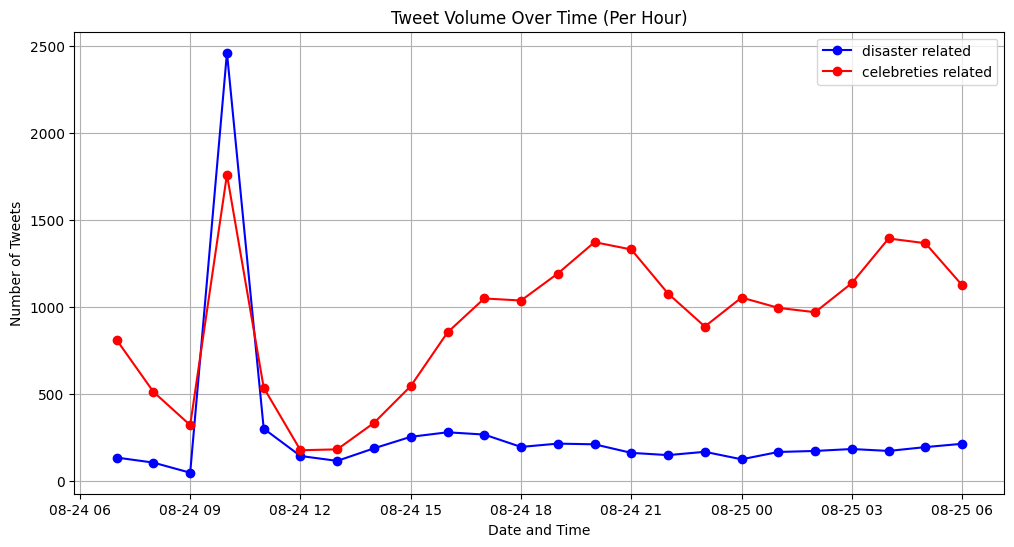

In [227]:
lowest_time = df["time"].min()
highest_time = df["time"].max()

disaster_tweets = df.loc[disaster_related_tweets_indices]
disaster_tweets_lt = disaster_tweets["time"].min()
disaster_tweets_ht = disaster_tweets["time"].max()

print(lowest_time, highest_time)
print(disaster_tweets_lt, disaster_tweets_ht)

timedf = disaster_tweets.copy()
timedf['time'] = pd.to_datetime(timedf['time'])
timedf.set_index('time', inplace=True)

timedf_football = football_tweets.copy()
timedf_football['time'] = pd.to_datetime(timedf_football['time'])
timedf_football.set_index('time', inplace=True)

disaster_tweet_volume_over_time = timedf.resample('H').size()
football_tvot = timedf_football.resample('H').size()
print(disaster_tweet_volume_over_time.head(5))

plt.figure(figsize=(12, 6))
plt.plot(disaster_tweet_volume_over_time.index, disaster_tweet_volume_over_time, marker='o', linestyle='-', color='b', label="disaster related")
plt.plot(football_tvot.index, football_tvot, marker='o', linestyle='-', color='r', label="celebreties related")
plt.title('Tweet Volume Over Time (Per Hour)')
plt.xlabel('Date and Time')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.legend()
plt.show()

time
2014-08-24 07:00:00     136
2014-08-24 08:00:00     107
2014-08-24 09:00:00      49
2014-08-24 10:00:00    2459
2014-08-24 11:00:00     302
Freq: H, dtype: int64


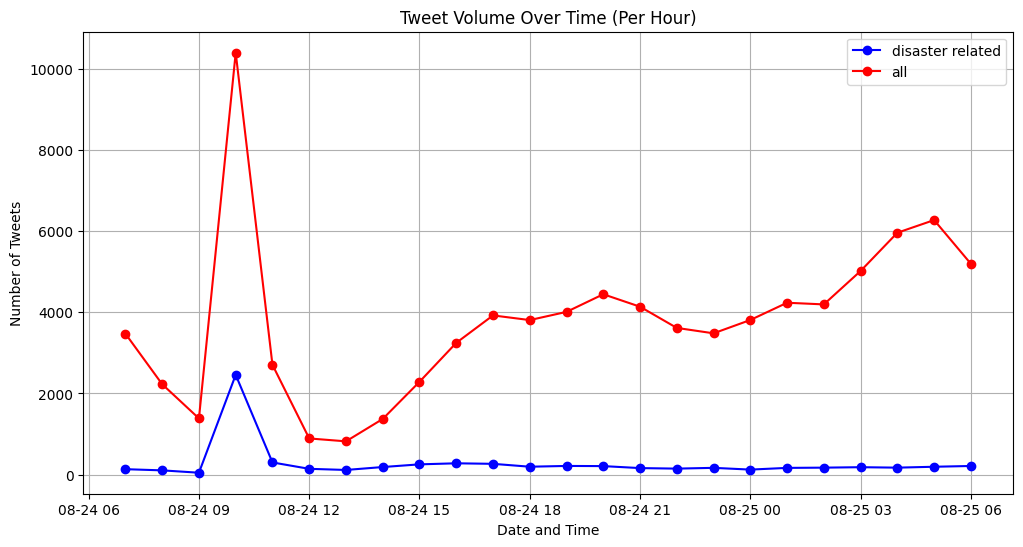

In [232]:
timedf = disaster_tweets.copy()
timedf['time'] = pd.to_datetime(timedf['time'])
timedf.set_index('time', inplace=True)

all_time = df.copy()
all_time['time'] = pd.to_datetime(all_time['time'])
all_time.set_index('time', inplace=True)

disaster_tweet_volume_over_time = timedf.resample('H').size()
all_volume = all_time.resample('H').size()
print(disaster_tweet_volume_over_time.head(5))

plt.figure(figsize=(12, 6))
plt.plot(disaster_tweet_volume_over_time.index, disaster_tweet_volume_over_time, marker='o', linestyle='-', color='b', label="disaster related")
plt.plot(all_volume.index, all_volume, marker='o', linestyle='-', color='r', label="all")
plt.title('Tweet Volume Over Time (Per Hour)')
plt.xlabel('Date and Time')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.legend()
plt.show()

## Check geospatial distribution

Display tweets on a ma and apply heatmap on the tweets. 

In [236]:
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
heat_data = [[point['latitude'], point['longitude']] for index, point in df.iterrows()]
HeatMap(heat_data).add_to(m)

print(len(df["tweet_text"]))

m

90907


In [237]:
## disaster only heatmap
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

m = folium.Map(location=[disaster_tweets['latitude'].mean(), disaster_tweets['longitude'].mean()], zoom_start=10)
heat_data = [[point['latitude'], point['longitude']] for index, point in disaster_tweets.iterrows()]
HeatMap(heat_data).add_to(m)

print(len(disaster_tweets["tweet_text"]))

m


6653


More information

* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Combining machine-learning topic models and spatiotemporal analysis of social media data for disaster footprint and damage assessment](https://www.tandfonline.com/doi/full/10.1080/15230406.2017.1356242)
* [Gensim](https://radimrehurek.com/gensim/)

# Classify Tweet sentiments

Finally, let us use a state-of-the-art artificial intelligence sentiment classification method, called RoBERTa. RoBERTA stands for Robustly Optimized BERT Pretraining Approach and can be used for different natural language processing tasks.

Orignal paper: https://arxiv.org/abs/1907.11692

Code source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment


## Load the model
Run the code below

In [ ]:
%pip install transformers
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


You should consider upgrading via the '/Users/izzy/.pyenv/versions/3.8.15/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

### Preprocessing the data

1. Remove user information
2. Remove URL

In [ ]:
def remove_mentions(text):
    return re.sub(r'@[\w_]+', '', text)

tweets_data = df.copy()

tweets_data["tweet_text"] = tweets_data['tweet_text'].apply(remove_mentions)
tweets_data["tweet_text"] = tweets_data['tweet_text'].apply(remove_urls)


## Test the model

Preprocess the text and apply autotokenizer by writing the function "get_sentiment"

In [ ]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens if re.sub(r'[^a-zA-Z]', '', word) != '']

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

text = "Good night 😊"
text = preprocess(text)
print(text)



good night


[nltk_data] Downloading package wordnet to /Users/izzy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    sentiment_label = torch.argmax(logits).item()

    return labels[sentiment_label]



In [ ]:
get_sentiment(text)

'positive'

#### Try your own examples


In [ ]:
should_be_negative = "i hurt myself badly"
should_be_neutral = "mhm, what are you doing?"
should_be_positive = "i love you"

print(get_sentiment(should_be_negative))
print(get_sentiment(should_be_neutral))
print(get_sentiment(should_be_positive))

negative
neutral
positive


## Classify the sentiment for a random sample of size 1000

1. Preprocess the data and apply tokenizer (measure time)

In [ ]:
df_sent = df.sample(1000)
df_sent['sentiment'] = 'no_sentiment'

In [ ]:
df_sent["tweet_text"] = df_sent["tweet_text"].apply(preprocess)

import time
start_time = time.time()

df_sent["sentiment"] = df_sent["tweet_text"].apply(get_sentiment)

end_time = time.time()
elapsed_time = end_time - start_time

print(round(elapsed_time, 4), " seconds")


152.5001  seconds


In [ ]:
print('Number of positive tweets: ', (len(df_sent[df_sent.sentiment == 'positive'])))
print('Number of positive tweets: ', (len(df_sent[df_sent.sentiment == 'neutral'])))
print('Number of negative tweets: ', (len(df_sent[df_sent.sentiment == 'negative'])))
print('It took %d seconds to get the sentiment for %d tweets'%((elapsed_time), len(df_sent)))

Number of positive tweets:  153
Number of positive tweets:  634
Number of negative tweets:  213
It took 152 seconds to get the sentiment for 1000 tweets


## Build and compare wordclouds according to the diffferent sentiments 

### Postive

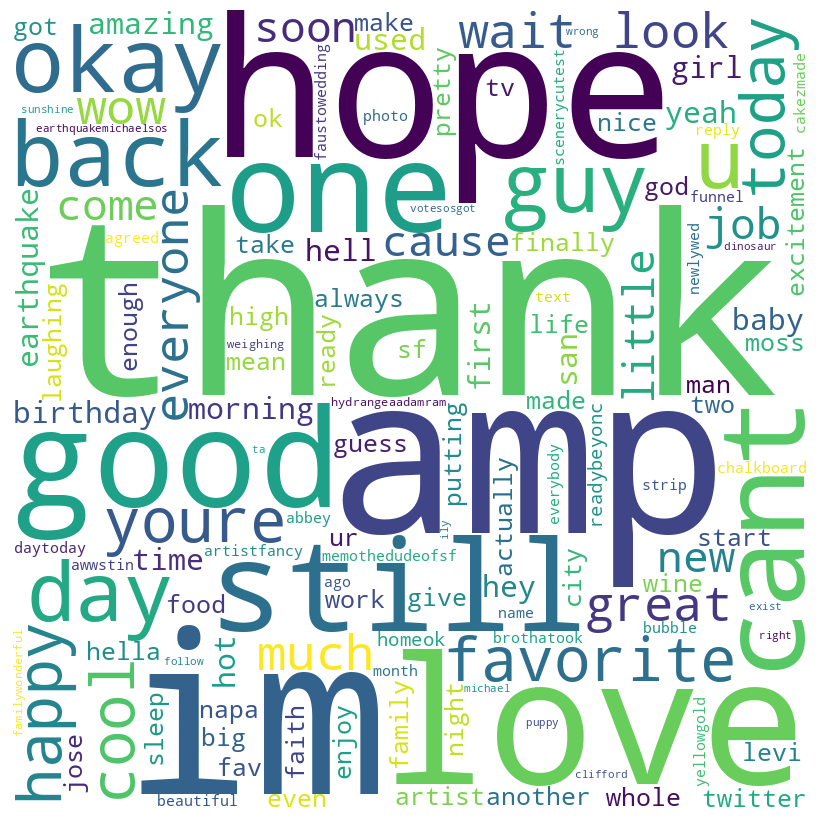

In [ ]:
positive_text = "".join(df_sent[df_sent.sentiment == 'positive']["tweet_text"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=set(STOPWORDS),
                min_font_size = 10).generate(positive_text)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Negative

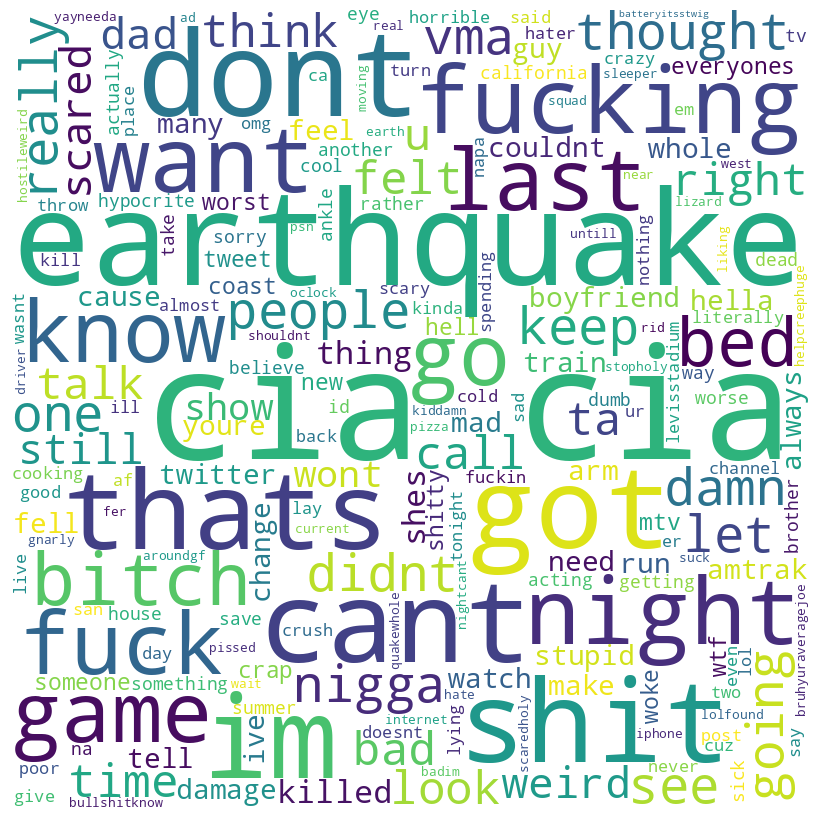

In [ ]:
negative_text = "".join(df_sent[df_sent.sentiment == 'negative']["tweet_text"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=set(STOPWORDS),
                min_font_size = 10).generate(negative_text)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Neutral

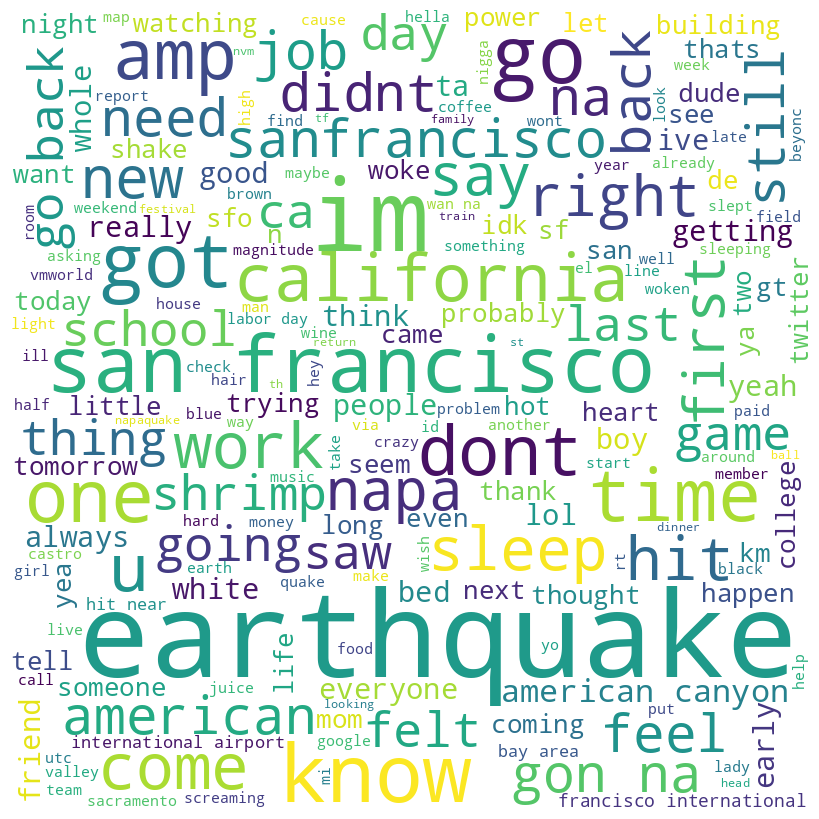

In [ ]:
neutral_text = "".join(df_sent[df_sent.sentiment == 'neutral']["tweet_text"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=set(STOPWORDS),
                min_font_size = 10).generate(neutral_text)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Compare sentiment timelines for different topics

Napa earthquake took place at 03:20:44 Pacific Daylight Time which is 10:20:44 in GMT

In [228]:
disaster_tweets["preprocessed_text"] = disaster_tweets["tweet_text"].apply(preprocess)
disaster_tweets["sentiment"] = disaster_tweets["preprocessed_text"].apply(get_sentiment)

# celeb_tweets["preprocessed_text"] = celeb_tweets["tweet_text"].apply(preprocess)
# celeb_tweets["sentiment"] = celeb_tweets["preprocessed_text"].apply(get_sentiment)

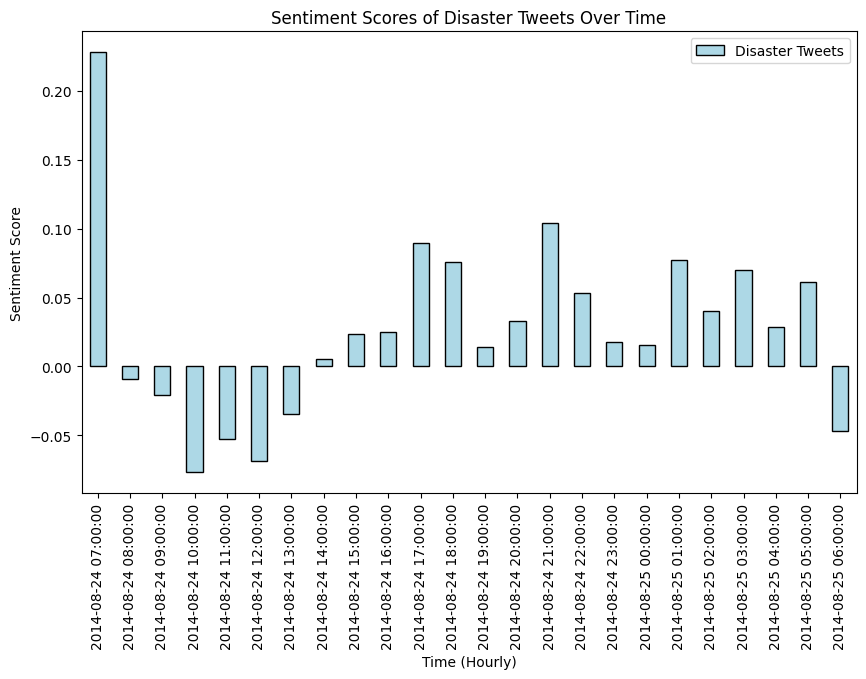

In [230]:
disaster_copy = disaster_tweets.copy()
# celeb_copy = celeb_tweets.copy()

disaster_copy['time'] = pd.to_datetime(disaster_copy['time'])
disaster_copy.set_index('time', inplace=True)
disaster_tweet_volume_over_time = disaster_copy.resample('H').size()

# celeb_copy['time'] = pd.to_datetime(celeb_copy['time'])
# celeb_copy.set_index('time', inplace=True)
# celeb_tweet_volume_over_time = celeb_copy.resample('H').size()

def calculate_sentiment_scores(df):
    positive_counts = df.resample('H')['sentiment'].apply(lambda x: len(x[x == 'positive']))
    neutral_counts = df.resample('H')['sentiment'].apply(lambda x: len(x[x == 'neutral']))
    negative_counts = df.resample('H')['sentiment'].apply(lambda x: len(x[x == 'negative']))
    
    total_counts = positive_counts + neutral_counts + negative_counts
    
    return (positive_counts - negative_counts) / total_counts

disaster_sentiment_scores = calculate_sentiment_scores(disaster_copy)
# celeb_sentiment_scores = calculate_sentiment_scores(celeb_copy)

plt.figure(figsize=(10, 6))
disaster_sentiment_scores.plot(kind='bar', color='lightblue', edgecolor='black', label='Disaster Tweets')
# celeb_sentiment_scores.plot(kind='bar', color='lightgreen', edgecolor='black', label='Celebrity Tweets', alpha=0.7)
plt.title('Sentiment Scores of Disaster Tweets Over Time')
plt.xlabel('Time (Hourly)')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()
